# **Main code to scrape the 13F from SEC website**

## **Introduction**

1. **Access SEC Website:**
   - Using the CIK from the csv list, we access the SEC website with the URL: `https://www.sec.gov/cgi-bin/browse-edgar?CIK={cik}&owner=exclude&action=getcompany&type=13F-HR`.

2. **Navigate to 13F Form:**
   - We check filings from newest to oldest. If the latest filing date on the website is newer than or equal to the one in our csv list, we run the `scrap_and_save_report()` function to extract the data.

   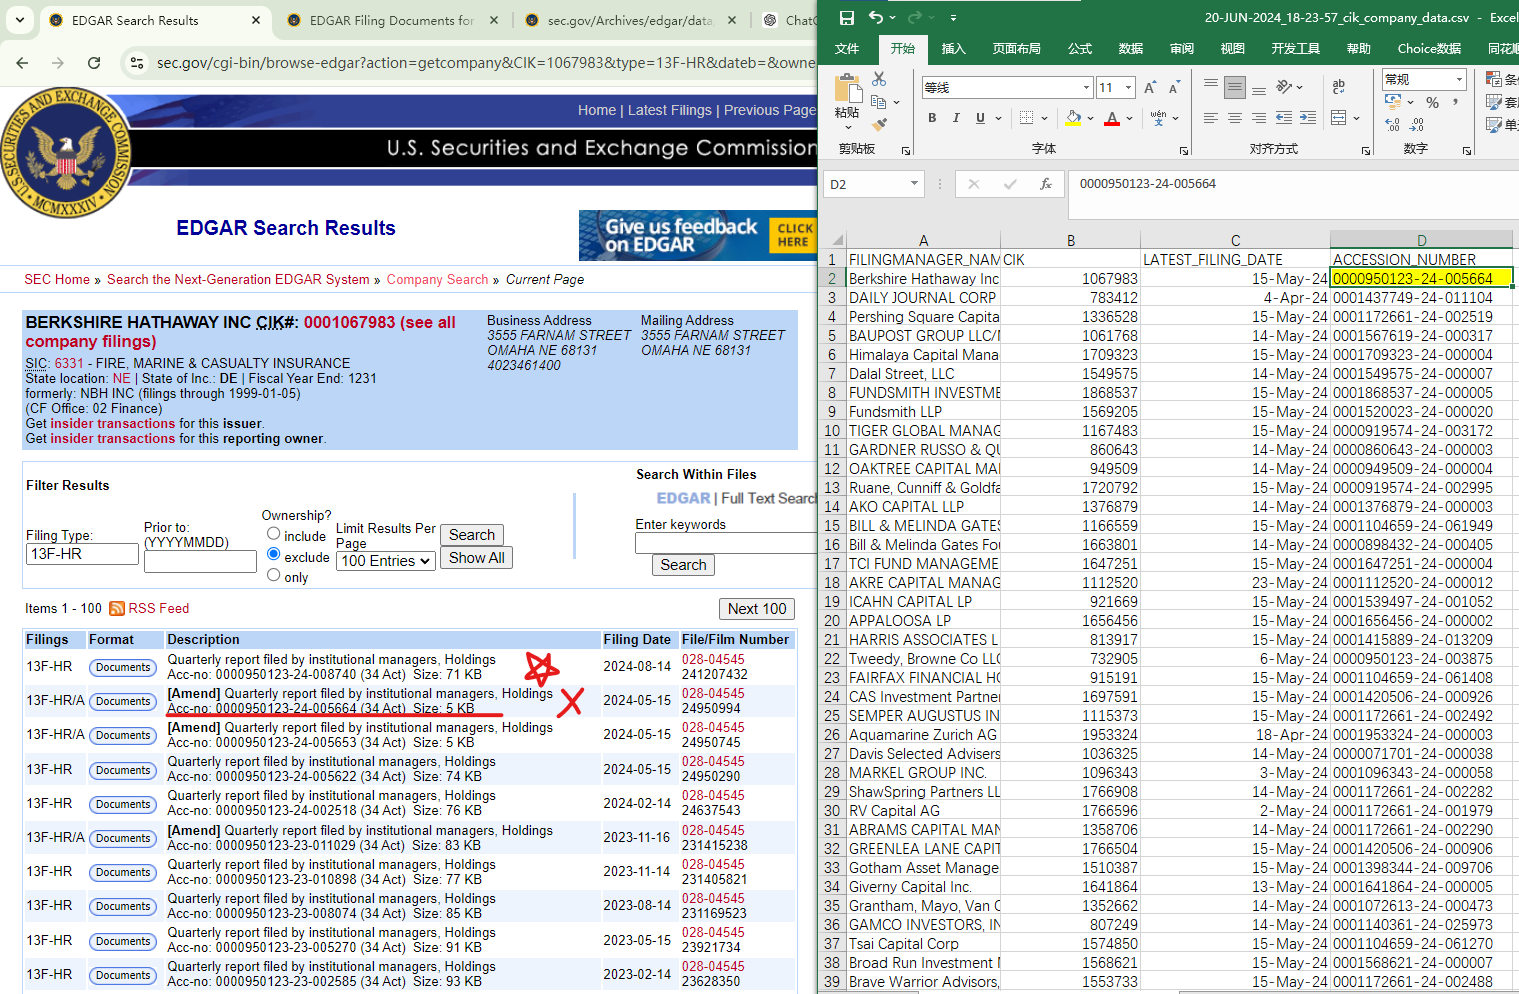

3. **Extract Initial Data:**
   - In the first layer, we use `findAll` to get `<a>` tags with `id='documentsbutton'` (saved in `tags`) and `<tr>` elements (saved in `rows`). The `tags` provide URLs for the next layer, while `rows` help determine if there’s a new or updated form.


   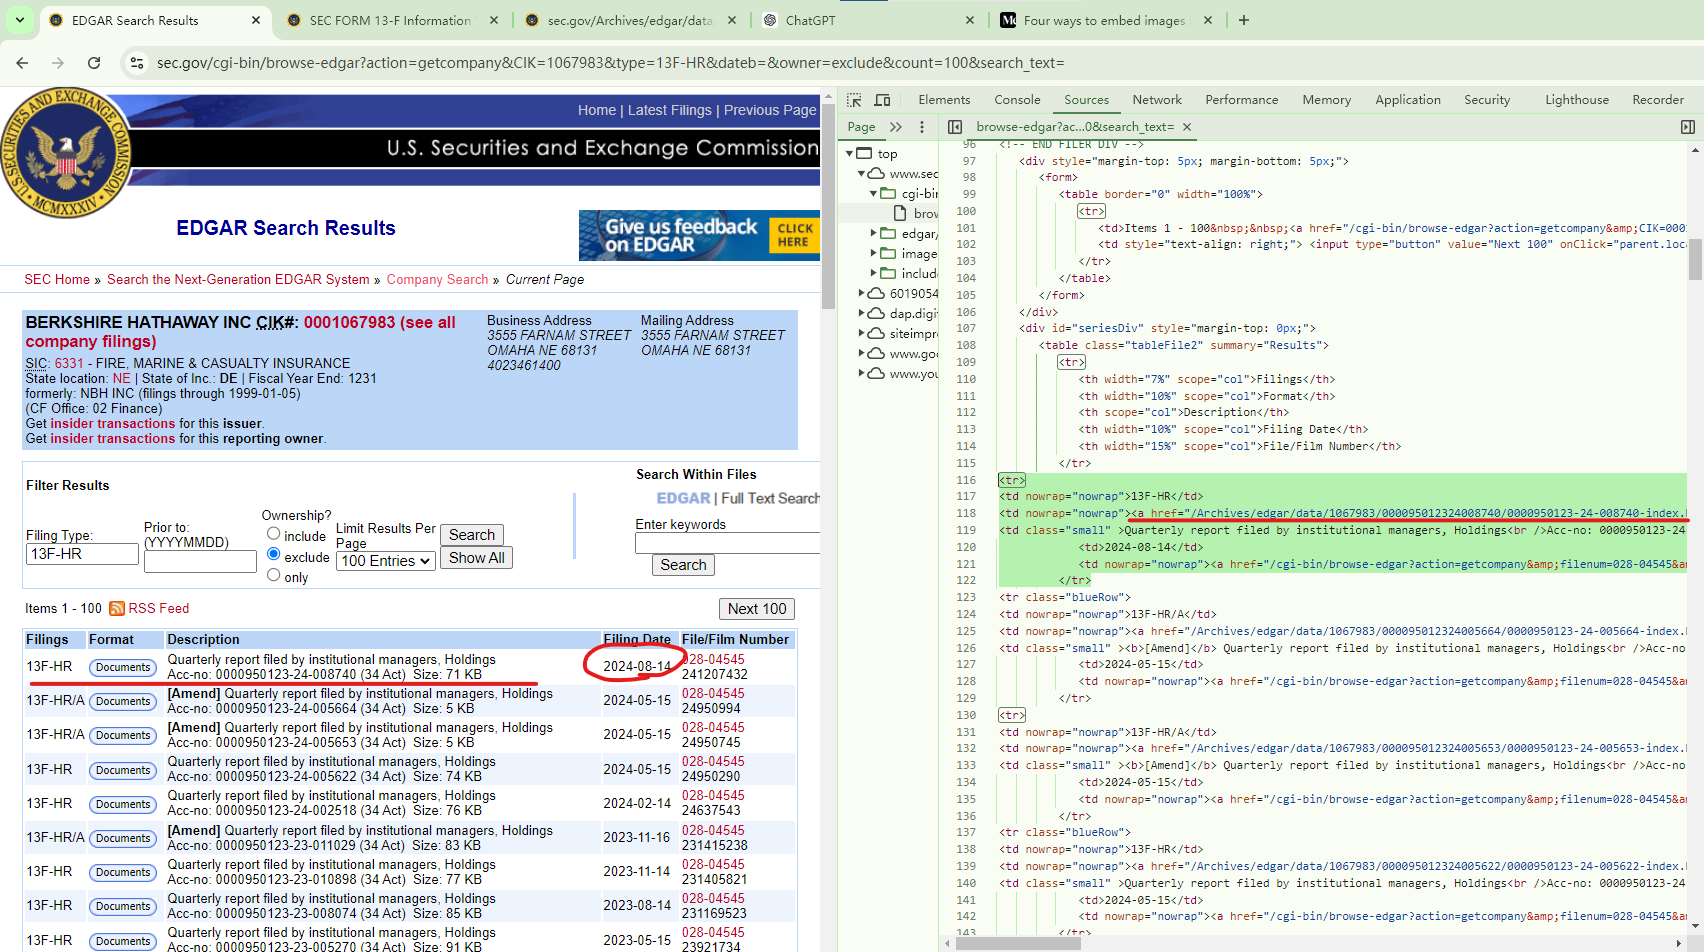

4. **Collect Key Information:**
   - In the second layer, we extract the period of report, filing date, and accession number. We also get the `xml_url` needed to access the actual 13F form.

   
   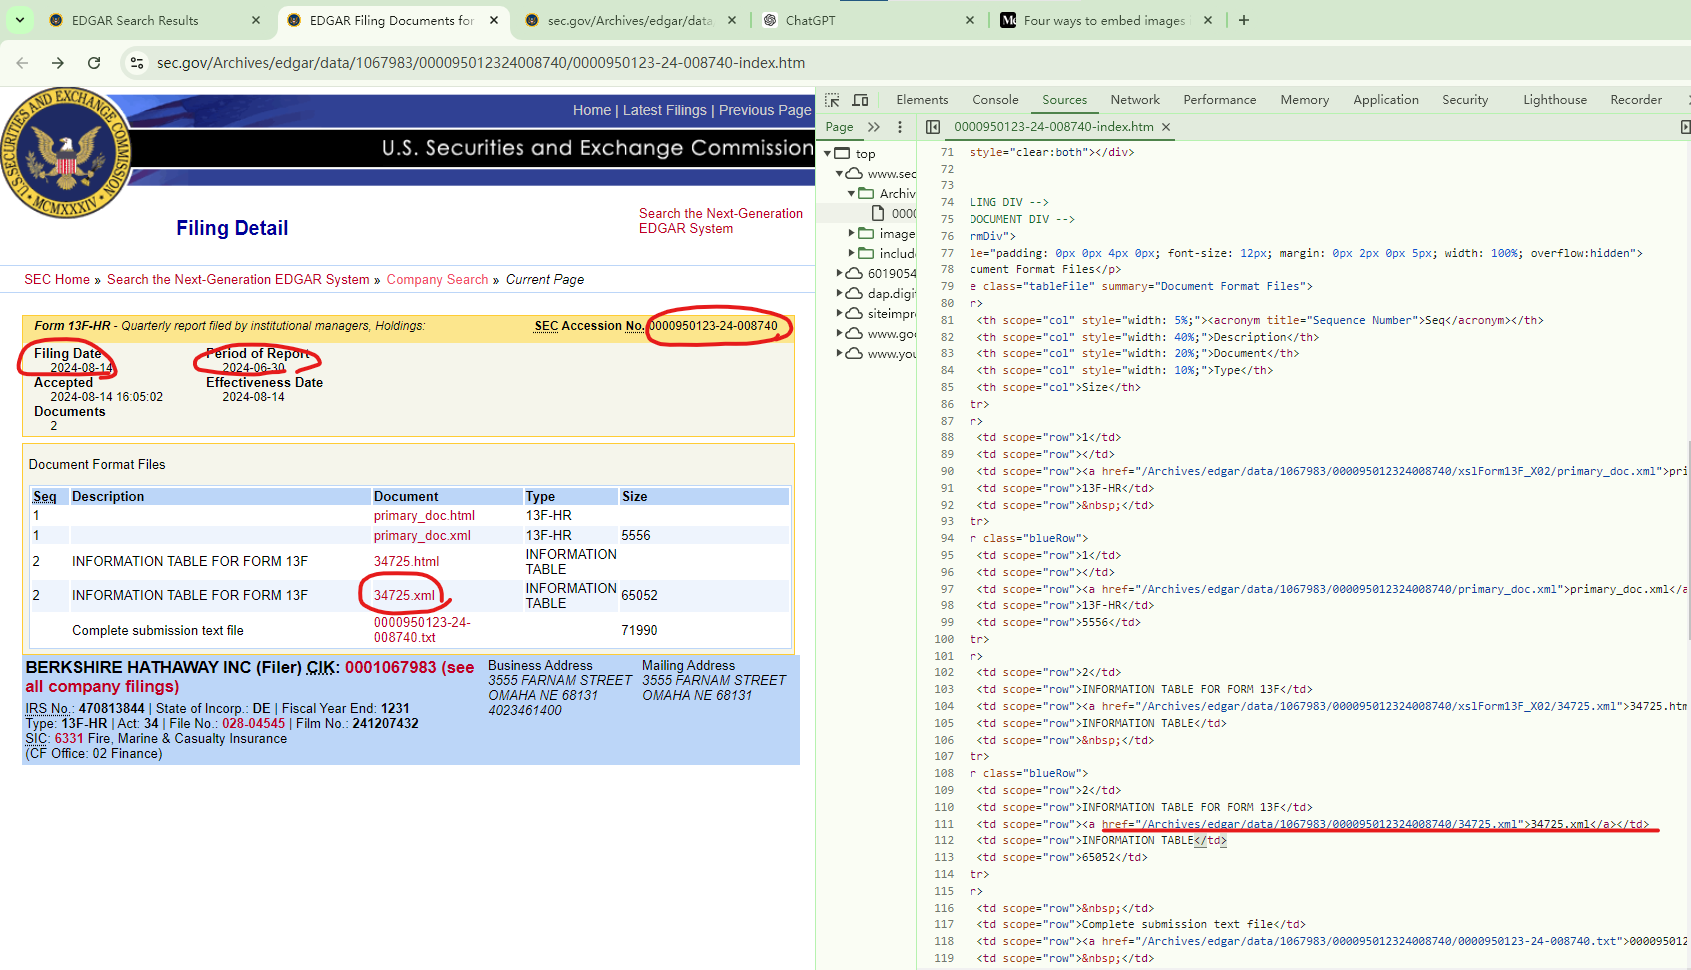

5. **Retrieve 13F Data:**
   - In the final layer, we use the `xml_url` to fetch the 13F form and extract all relevant data with `findAll`. The `scrap_and_save_report` function compiles this into a DataFrame and moves on to the next manager.

6. **Process and Save Results:**
   - The `process_ciks` function runs through all CIKs, calling `scrap_and_save_report` for each. It aggregates data for the same stock, returns a DataFrame of all managers' 13F forms, lists new filings, and save a new csv file with the latest information.


## **Import Packages**

In [1]:
import os
import re
import warnings
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

## **Define Functions**

In [2]:

# Define the headers in order to get access to the SEC website, you can replace with your preferred email
headers = {
    'User-Agent': 'shengwei.huang@me.com',
    'Accept-Encoding': 'gzip, deflate, br',
    'HOST': 'www.sec.gov',
}
sec_url = 'https://www.sec.gov'


def get_request(url):
    return requests.get(url, headers=headers)

# The main url we get access to all fund manager's 13F
def create_url(cik):
    return f'https://www.sec.gov/cgi-bin/browse-edgar?CIK={cik}&owner=exclude&action=getcompany&type=13F-HR'

# Coverting the date format to we want
def convert_date_format(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m-%d').upper()
    except ValueError:
        return date_str

# Get the latest filing date to see whether run into the next action
def get_latest_filing_date(cik):
    try:
        path = create_url(cik)
        response = get_request(path)
        soup = BeautifulSoup(response.text, "html.parser")
        tags = soup.findAll('a', id='documentsbutton')
        rows = soup.findAll('tr')

        report_url = None
        for i, row in enumerate(rows[5:]):
            cols = row.findAll('td')
            if len(cols) > 3 and '13F-HR' in cols[0].text: # WE get the latest row, to get it's filing date
                report_url = sec_url + cols[1].a['href']
                break

        if report_url is None:
            print(f"No 13F-HR form found for CIK {cik}")
            return None

        last_report = sec_url + tags[i]['href']
        response_two = get_request(last_report)
        soup_two = BeautifulSoup(response_two.text, "html.parser")

        text_content = soup_two.get_text()
        filing_date_match = re.search(r'Filing Date\s*(\d{4}-\d{2}-\d{2})', text_content)
        filing_date = convert_date_format(filing_date_match.group(1)) if filing_date_match else "N/A"

        return filing_date

    except Exception as e:
        print(f"An error occurred for CIK {cik}: {e}")
        return None

# Main function to scrap all new 13F form for one fund manager
def scrap_and_save_report(requested_cik, company_name, access):
    try:
        path = create_url(requested_cik)
        warnings.filterwarnings("ignore", category=UserWarning, module='bs4.builder', lineno=545)
        response = get_request(path)
        soup = BeautifulSoup(response.text, "html.parser")
        tags = soup.findAll('a', id="documentsbutton") # List for all second layer url
        rows = soup.findAll('tr') # information to see whether go access to the next layer

        report_url = None
        filing_list = []
        for i, row in enumerate(rows[5:]):
            cols = row.findAll('td')
            if len(cols) > 3 and '13F-HR' in cols[0].text:
                if access in cols[2].text: # If the access match with the csv access number, which means that we already scrap this form, then we break the loop
                    break                   
                else:
                    if '13F-HR/A' in cols[0].text:
                        filing_list.append("13F-HR/A")
                    else:
                        filing_list.append("13F-HR")
                    pass
        if i == 0:
            return None
        
        columns = [
            "FILING",
            "ACCESSION_NUMBER",
            "PERIODOFREPORT",
            "FILING_DATE",
            "FILINGMANAGER_NAME",
            "CIK",
            "CUSIP",
            "TITLEOFCLASS",
            "NAMEOFISSUER",
            "SSHPRNAMT",
            "VALUE",
        ]

        df = pd.DataFrame(columns=columns)

        for j in range(i): # i is the number of url we save in tags

            # Second Layer
            last_report = sec_url + tags[j]['href']
            response_two = get_request(last_report)
            soup_two = BeautifulSoup(response_two.text, "html.parser")
            tags_two = soup_two.findAll('a', attrs={'href': re.compile('xml')}) # tags_two is the xml list in second layer
            xml_url = tags_two[-1].get('href') # xml_url is the xml we want to get access to the third layer

            text_content = soup_two.get_text() # in the second layer, we can get the Accession number, filing date, period of report.
            acc_no_match = re.search(r'SEC Accession No. (\d{10}-\d{2}-\d{6})', text_content)
            acc_no = acc_no_match.group(1)
            filing_date_match = re.search(r'Filing Date\s*(\d{4}-\d{2}-\d{2})', text_content)
            filing_date = convert_date_format(filing_date_match.group(1)) if filing_date_match else "N/A"
            period_of_report_match = re.search(r'Period of Report\s*(\d{4}-\d{2}-\d{2})', text_content)
            period_of_report = convert_date_format(period_of_report_match.group(1)) if period_of_report_match else "N/A"

            # Third Layer
            response_xml = get_request(sec_url + xml_url) 
            soup_xml = BeautifulSoup(response_xml.content, "lxml")

            # Get all the information we want in 13F form
            issuers = soup_xml.body.findAll(re.compile('nameofissuer'))
            titleofclasses = soup_xml.body.findAll(re.compile('titleofclass'))
            cusips = soup_xml.body.findAll(re.compile('cusip'))
            values = soup_xml.body.findAll(re.compile('value'))
            sshprnamts = soup_xml.body.findAll(re.compile('sshprnamt'))

            for k in range(len(issuers)):
                cusip = str((cusips[k].text).upper().zfill(9))
                df.loc[len(df)] = [
                    filing_list[j],
                    acc_no,
                    period_of_report,
                    filing_date,
                    company_name,
                    int(requested_cik),
                    cusip,
                    titleofclasses[k].text,
                    issuers[k].text,
                    int(sshprnamts[2 * k].text),
                    int(values[k].text)
                ]

        return df # Return a DataFrame of all new update 13F form for one manager

    except Exception as e:
        print(f"An error occurred for CIK {requested_cik}: {e}")
        return None

# Main Function
def process_ciks(cik_company_df):
    all_dfs = []
    filing = []
    no_filing = []

    # According to the csv list, run all fund managers
    for index, row in cik_company_df.iterrows():
        requested_cik = str(row['CIK'])
        access = str(row['ACCESSION_NUMBER'])
        company_name = row['FILINGMANAGER_NAME']
        
        # Get the LATEST_FILING_DATE from our csv file
        latest_csv_filing_date = row['LATEST_FILING_DATE']
        latest_csv_filing_date = datetime.strptime(latest_csv_filing_date, '%d-%b-%y')

        # Get the LATEST_FILING_DATE from website
        latest_website_filing_date = get_latest_filing_date(requested_cik)
        latest_website_filing_date = datetime.strptime(latest_website_filing_date, '%Y-%m-%d' ) if latest_website_filing_date else None

        # To see if there is a new update from the manager, otherwise we just skip to the next manager
        if latest_website_filing_date and latest_website_filing_date >= latest_csv_filing_date:
            result_df = scrap_and_save_report(requested_cik, company_name, access)
            if result_df is not None:

                # combine the result_df to all_dfs, which contains all managers forms
                all_dfs.append(result_df)

                # Form a new csv file for LATEST_FILING_DATE and ACCESSION_NUMBER
                cik_company_df.loc[index, 'LATEST_FILING_DATE'] = latest_website_filing_date.strftime('%d-%b-%y')
                cik_company_df.loc[index, 'ACCESSION_NUMBER'] = result_df['ACCESSION_NUMBER'].iloc[0]
                print(f"New fillings for CIK {requested_cik}")
                filing.append(requested_cik)
            else:
                no_filing.append(requested_cik)
                print(f"No new filings for CIK {requested_cik}")
        else:
            print(f"No new filings for CIK {requested_cik}")
            no_filing.append(requested_cik)

    return all_dfs,filing, no_filing

def save_data_to_csv(all_dfs, output_dir, cik_company_df, output_dir_manager_list):


    # Handle the duplicate rows for the same stocks, we sum up the shares and values, and save the file (13F, cik_company csv list)
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)

        grouped_df = final_df.groupby(["CIK", "CUSIP","ACCESSION_NUMBER"], as_index=False).agg({
            "FILING": "first",
            "ACCESSION_NUMBER": "first",
            "PERIODOFREPORT": "first",
            "FILING_DATE": "first",
            "FILINGMANAGER_NAME": "first",
            "TITLEOFCLASS": "first",
            "NAMEOFISSUER": "first",
            "SSHPRNAMT": "sum",
            "VALUE": "sum"
        })

        grouped_df['PERCENT'] = grouped_df.groupby("CIK")['VALUE'].transform(lambda x: x / x.sum())

        grouped_df['CIK'] = grouped_df['CIK'].apply(lambda x: str(x).zfill(10))
        current_date_time = datetime.now().strftime('%d-%b-%Y_%H-%M-%S').upper()
        final_output_path = os.path.join(output_dir, f"{current_date_time}.csv")
        columns = [
            "FILING",
            "ACCESSION_NUMBER",
            "PERIODOFREPORT",
            "FILING_DATE",
            "FILINGMANAGER_NAME",
            "CIK",
            "CUSIP",
            "TITLEOFCLASS",
            "NAMEOFISSUER",
            "SSHPRNAMT",
            "VALUE",
            "PERCENT"
        ]
        
        

        grouped_df = grouped_df[columns]
        grouped_df.to_csv(final_output_path, index=False)

        cik_company_output_path = os.path.join(output_dir_manager_list, f"{current_date_time}_manager_list_date.csv")
        cik_company_df.to_csv(cik_company_output_path, index=False)




In [4]:
# Example usage:
file_path = r"C:\Users\Analyst\Desktop\Will\13F\13F Manager List\21-AUG-2024_09-25-32_manager_list_date.csv"
cik_company_df = pd.read_csv(file_path)

# Process CIKs and collect dataframes
all_dfs, filing, no_filing = process_ciks(cik_company_df)

# Save collected dataframes to CSV
folder_name = "13F Web Scrape"
output_dir = os.path.join(r"C:\Users\Analyst\Desktop\Will\13F", folder_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_dir_manager_list = r'C:\Users\Analyst\Desktop\Will\13F\13F Manager List'

save_data_to_csv(all_dfs, output_dir, cik_company_df, output_dir_manager_list)

print("Filing:", filing)
print("No Filing:", no_filing)
print('There are %s managers update new form' % len(filing) )

No new filings for CIK 200217
No new filings for CIK 732905
No new filings for CIK 783412
No new filings for CIK 807249
No new filings for CIK 807985
No new filings for CIK 813917
No new filings for CIK 814375
No new filings for CIK 820124
No new filings for CIK 846222
No new filings for CIK 859804
No new filings for CIK 860643
No new filings for CIK 883965
No new filings for CIK 898382
No new filings for CIK 915191
No new filings for CIK 921669
No new filings for CIK 936753
No new filings for CIK 945631
No new filings for CIK 947996
No new filings for CIK 948669
No new filings for CIK 949509
No new filings for CIK 1015079
No new filings for CIK 1016287
No new filings for CIK 1027796
No new filings for CIK 1036325
No new filings for CIK 1039565
No new filings for CIK 1050442
No new filings for CIK 1056831
No new filings for CIK 1061165
No new filings for CIK 1061768
No new filings for CIK 1063296
No new filings for CIK 1067983
No new filings for CIK 1096343
No new filings for CIK 10992